In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from getpass import getuser



c:\Users\ALESSANDRO\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Get the current user's name
user = getuser()

# Path to the dataset
data_path = rf'C:\Users\{user}\Documents\GitHub\dream-team-fpl-prediction\data\final_ds\ds_def.xlsx'

# Read the dataset
df = pd.read_excel(data_path)

In [3]:
# Filter the dataset to include only rows where 'pos_player_1' is "DF" (Defenders)
defenders_data = df[df['pos_player_1'] == 'DF']

# Display the first few rows of the filtered dataset
defenders_data.head()

# Select numeric columns only (excluding non-numeric ones like player names)
numeric_defenders_data = defenders_data.select_dtypes(include=['number'])

# Drop rows with missing values
numeric_defenders_data = numeric_defenders_data.dropna()


Top 5 important features: ['bps' 'clean_sheets' 'selected_by_percent' 'goals_conceded' 'bonus']

Analyzing feature: bps
               Feature  Importance
3            influence    0.528676
11          min_player    0.109347
12          90s_player    0.091306
27         prgp_player    0.065366
6                 cost    0.028079
10       starts_player    0.025602
9            mp_player    0.018937
89  shots_blocked_team    0.015855
5            ict_index    0.008159
32           poss_team    0.007653


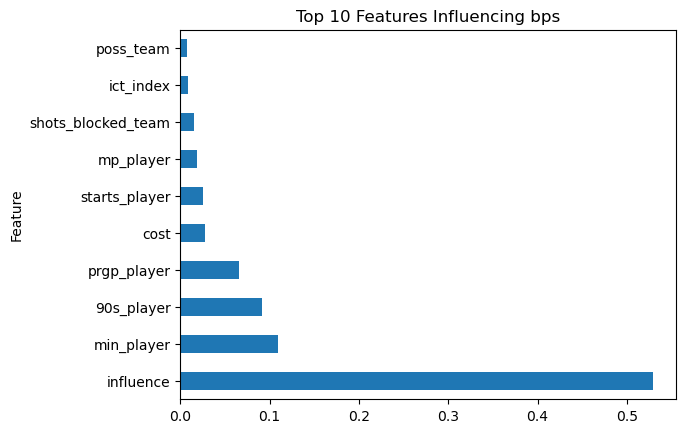


Analyzing feature: clean_sheets
               Feature  Importance
11          min_player    0.191043
12          90s_player    0.132246
10       starts_player    0.079169
39           crdy_team    0.041955
80        tkl_def_team    0.040033
27         prgp_player    0.038022
89  shots_blocked_team    0.033277
41  gls_90minutes_team    0.029903
3            influence    0.023932
33            gls_team    0.021313


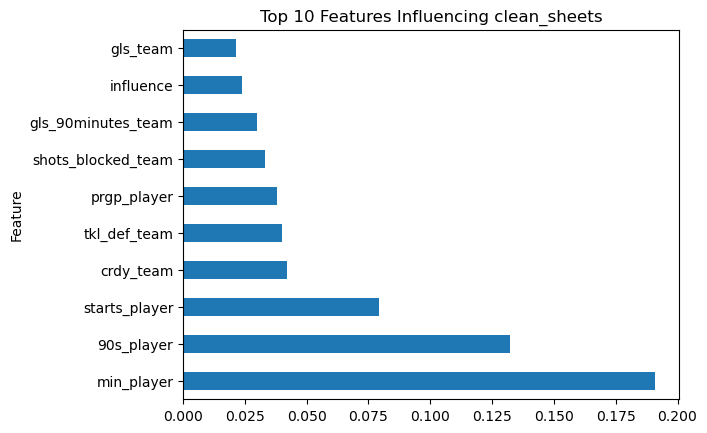


Analyzing feature: selected_by_percent
            Feature  Importance
6              cost    0.210269
5         ict_index    0.139535
27      prgp_player    0.106513
20       xag_player    0.056450
3         influence    0.055012
21  npxg+xag_player    0.048109
11       min_player    0.035846
9         mp_player    0.022587
28      prgr_player    0.019644
12       90s_player    0.017846


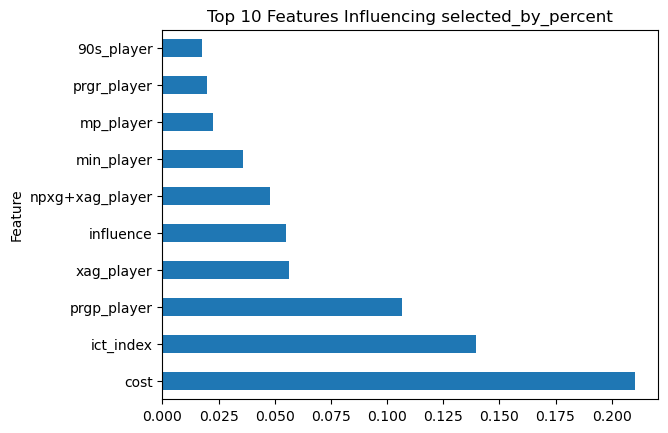


Analyzing feature: goals_conceded
               Feature  Importance
11          min_player    0.312097
12          90s_player    0.176766
66       blocks_player    0.057364
71     blocks_player.1    0.057111
32           poss_team    0.022799
51           prgp_team    0.021915
89  shots_blocked_team    0.017988
10       starts_player    0.017841
87         blocks_team    0.016172
33            gls_team    0.016112


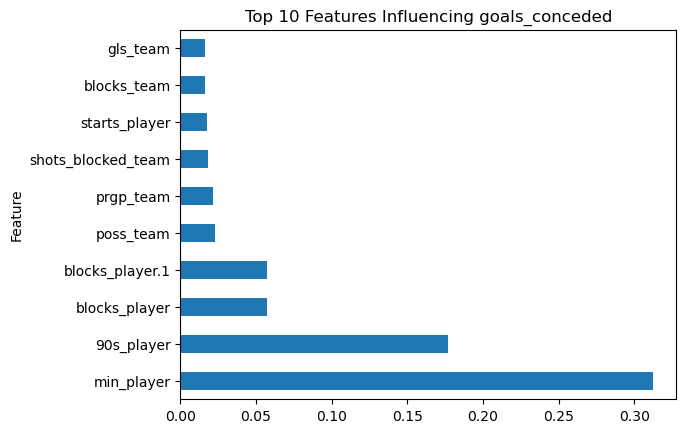


Analyzing feature: bonus
               Feature  Importance
5            ict_index    0.229228
20          xag_player    0.206889
2           creativity    0.089221
3            influence    0.055062
27         prgp_player    0.051050
6                 cost    0.030065
28         prgr_player    0.013756
39           crdy_team    0.010259
89  shots_blocked_team    0.009108
1              assists    0.009055


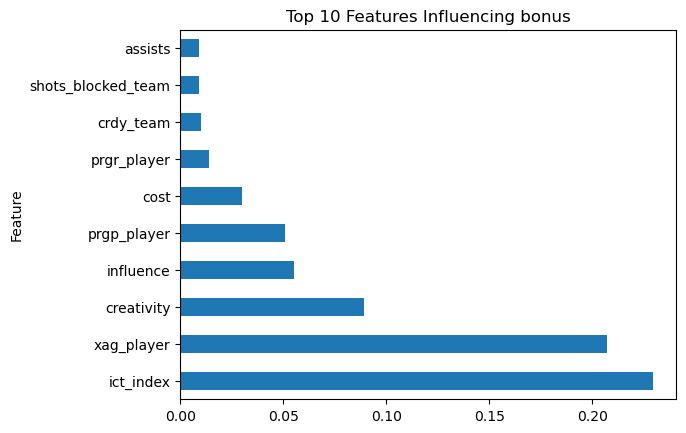

In [4]:
# Define features (X) and target variable (y)
X = numeric_defenders_data.drop(columns=['total_points'])  # Drop target variable from features
y = numeric_defenders_data['total_points']  # Total points as target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Feature importance from the original Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Extract the top 5 most important features
top_5_features = importance_df['Feature'].head(5).values
print(f"Top 5 important features: {top_5_features}")

# For each of the top 5 features, train a Random Forest model excluding these features
for feature in top_5_features:
    print(f"\nAnalyzing feature: {feature}")
    
    # Remove the top 5 features from the dataset for this analysis
    X_secondary = numeric_defenders_data.drop(columns=['total_points'] + list(top_5_features))
    
    # Set the target as the current feature we are analyzing
    y_secondary = numeric_defenders_data[feature]
    
    # Split the data into training and testing sets
    X_train_secondary, X_test_secondary, y_train_secondary, y_test_secondary = train_test_split(
        X_secondary, y_secondary, test_size=0.2, random_state=42)
    
    # Train the RandomForestRegressor for the current feature
    rf_model_secondary = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_secondary.fit(X_train_secondary, y_train_secondary)
    
    # Feature importance for this feature
    feature_importances_secondary = rf_model_secondary.feature_importances_
    
    # Create a DataFrame to display feature importance
    importance_df_secondary = pd.DataFrame({'Feature': X_secondary.columns, 'Importance': feature_importances_secondary})
    importance_df_secondary = importance_df_secondary.sort_values(by='Importance', ascending=False)
    
    # Display the top influencing features for the current top 5 feature
    print(importance_df_secondary.head(10))
    
    # Plot the top 10 important features for the current feature
    importance_df_secondary.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
    plt.title(f'Top 10 Features Influencing {feature}')
    plt.show()

In [7]:
def minmax(series):
    return (series - series.min()) / (series.max() - series.min())

df['defensive_score'] = (
    minmax(df['blocks_player']) +
    minmax(df['shots_blocked_player']) +
    minmax(df['min_player']) +
    minmax(df['starts_player'])
) / 4


In [8]:
df['attacking_score'] = (
    minmax(df['xag_player']) +
    minmax(df['creativity']) +
    minmax(df['ict_index']) +
    minmax(df['influence'])
) / 4



In [12]:
df['DPM'] = (
    0.6 * df['defensive_score'] +
    0.4 * df['attacking_score']
)

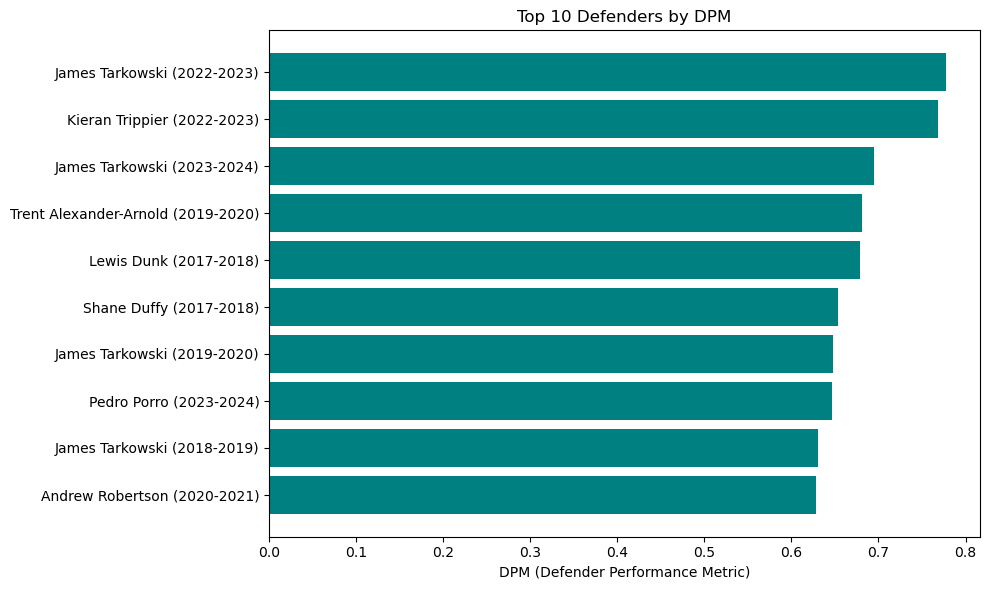

In [13]:
# Top 10 defenders by DPM
top10 = df[['player', 'season', 'DPM']].sort_values(by='DPM', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top10['player'] + " (" + top10['season'].astype(str) + ")", top10['DPM'], color='teal')
plt.xlabel("DPM (Defender Performance Metric)")
plt.title("Top 10 Defenders by DPM")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
